# TOC

__Lab 07 - Classification__
1. [Import](#Import)
1. [Multi-class classification](#Multi-class-classification)
    1. [Example 1 - Distance from planes](#Distance-from-planes-Example1)
    1. [Example 2 - Iris classification w/ logistic regression](#Iris-classification-w/-logistic-regression-Example2)


# Import

<a id = "Import"></a>

In [1]:
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:78% !important; }</style>"))

import os
import itertools

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import load_iris, fetch_mldata
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid", font_scale=1.3)

# Multi-class classification

Tne method for classifying an observation in a multi-class problem is to calculate the perpendicular distance of the observation from each of the separating planes. The shortest distance is the class selection.

<a id = "Multi-class-classification"></a>

## Example 1 - Distance from planes
Consider a three-class classification problem with the following separating hyperplanes:

$$
\begin{align}
x_1 + x_2 - 2 = 0 & & 1^{\text{st}} \text{ class}\\
-4x_1 + 3x_2 - 11 = 0 & & 2^{\text{nd}} \text{ class}\\
-x_1 - 3x_2 - 1 = 0 & & 3^{\text{rd}} \text{ class}
\end{align}
$$

Calculate the score (unnormalized perpendicular distance) for each class for the test case $(x_1, x_2)=(0, 1)$ .


<a id = "Distance-from-planes-Example1"></a>

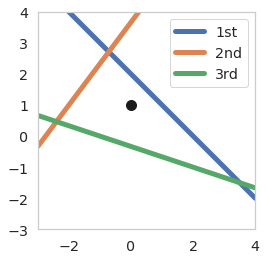

In [2]:
# plot planes and observation
x = np.arange(-3, 5)
plt.plot(x, (2.0 - 1 * x) / 1.0, label="1st", lw=5)
plt.plot(x, (11.0 + 4 * x) / 3.0, label="2nd", lw=5)
plt.plot(x, (-1.0 - 1 * x) / 3.0, label="3rd", lw=5)

plt.gca().set_aspect("equal", adjustable="box")
plt.scatter([0], [1], c="k", s=100)
plt.xlim([-3, 4])
plt.ylim([-3, 4])
plt.grid()
plt.legend()
plt.show()

In [3]:
# build arrays for weights, bias units and observations
W = np.transpose(np.array([[1.0, 1.0], [-4, 3.0], [-1.0, -3.0]])).reshape(2, 3)
b = np.array([-2.0, -11.0, -1.0])

# test point
x = np.array([0.0, 1.0])

In [4]:
# review data
print(W)
print(b)
print(x)

[[ 1. -4. -1.]
 [ 1.  3. -3.]]
[ -2. -11.  -1.]
[0. 1.]


In [5]:
# determine distance from each plane
def scores(W, b, x):
    return np.dot(x, W) + b


scores(W, b, x)

array([-1., -8., -4.])

> Observations is closest to class 1

In [6]:
# determine probabilities associated with predictions
def probas(W, b, x):
    sc = scores(W, b, x)
    scExp = np.exp(sc)
    return scExp / np.sum(scExp)


np.round(probas(W, b, x), 5)

array([0.95175, 0.00087, 0.04738])

> .95 probability that observatation belongs to class one

In [7]:
# generate the answer
def predictClass(W, b, x):
    prob = probas(W, b, x)
    return np.argmax(prob) + 1


predictClass(W, b, x)

1

> Class 1 is chosen

## Example 2 - Iris classification w/ logistic regression
Build a classifier to identify an iris sample as belonging to one of three iris classes based on four features.

<a id = "Iris-classification-w/-logistic-regression-Example2"></a>

In [8]:
# load data
iris = load_iris()

In [9]:
# create observation and label datasets
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [10]:
# nspect features
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [11]:
# inspect feature summary statistics
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


>All the features here are numeric numerical features

__EDA__

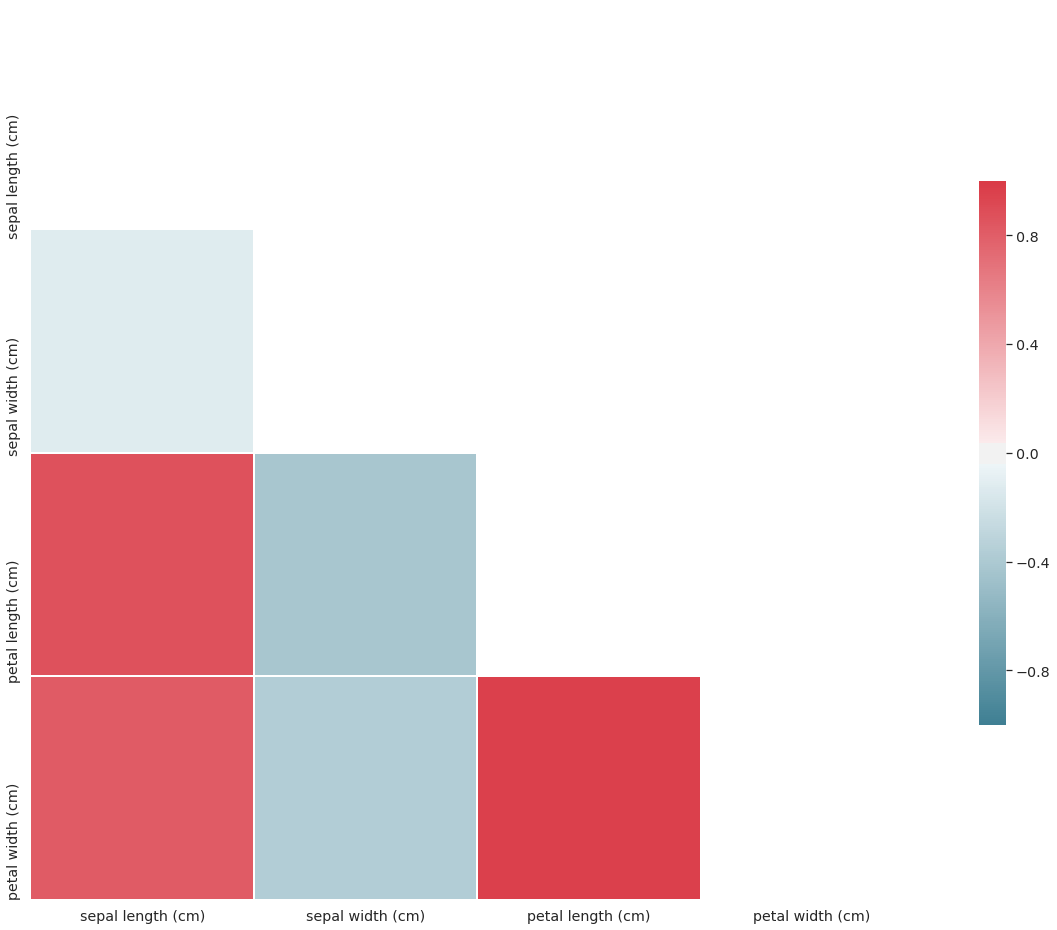

In [12]:
# correlation matrix
classLabels = ["setosa", "versicolour", "virginica"]

corr = X.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmin=-1.0,
    vmax=1.0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)

>Petal width and petal length are strongly positively correlated. Petal length and width are somewhat negatively correlated with sepal width.

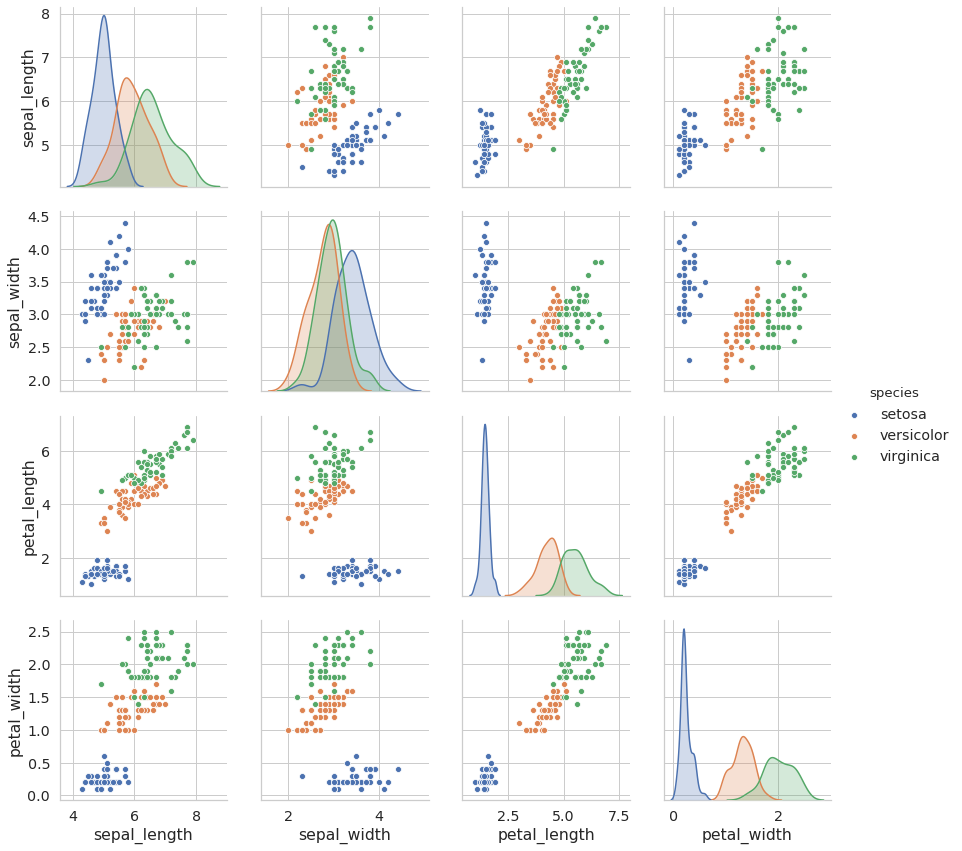

In [13]:
# pair-wise plots
sns.pairplot(sns.load_dataset("iris"), hue="species", size=3)

>The correlations describes above are apparent. Additionaly the setosa class (identified by blue dots) is often completely separated from the versicolor and virginica classes.

In [14]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# fitting
logReg = LogisticRegression(C=1e6, multi_class="multinomial", solver="lbfgs")
logReg.fit(X_train, y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

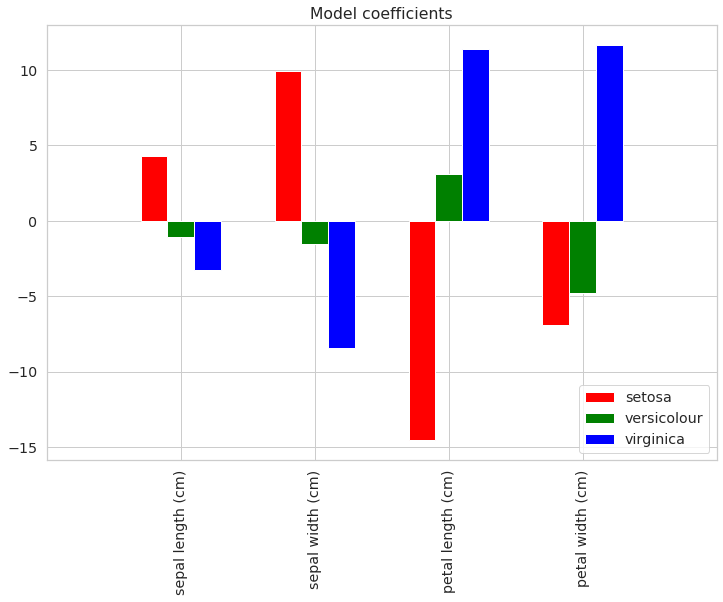

In [16]:
# model evaluation
plt.figure(figsize=(12, 8))
plt.bar(
    np.arange(logReg.coef_.shape[1]) - 0.2,
    logReg.coef_[0],
    color="red",
    width=0.2,
    label="setosa",
)
plt.bar(
    np.arange(logReg.coef_.shape[1]) - 0.0,
    logReg.coef_[1],
    color="green",
    width=0.2,
    label="versicolour",
)
plt.bar(
    np.arange(logReg.coef_.shape[1]) + 0.2,
    logReg.coef_[2],
    color="blue",
    width=0.2,
    label="virginica",
)
plt.xticks(np.arange(logReg.coef_.shape[1]), X.columns, rotation=90)
plt.xlim(-1, logReg.coef_.shape[1])
plt.title("Model coefficients")
plt.legend(loc="lower right")

>The most pronounced features in terms of the coefficients are pedal length and pedal width. This is consistent with then pairwise plots above in the these features seem to have clear divisions between each class.

In [17]:
# test set predictions
yPredsTrain = logReg.predict(X_train)
yPredsTest = logReg.predict(X_test)

In [18]:
# review accuracy
print("Train accuracy: ", np.round(accuracy_score(y_train, yPredsTrain), 3))
print("Test accuracy: ", np.round(accuracy_score(y_test, yPredsTest), 3))

Train accuracy:  0.983
Test accuracy:  1.0


In [19]:
# log results
results = pd.DataFrame(columns=["Accuracy"])
results = results.append(
    pd.DataFrame(
        [
            np.round(accuracy_score(y_train, yPredsTrain), 3),
            np.round(accuracy_score(y_test, yPredsTest), 3),
        ],
        columns=["Accuracy"],
        index=["Sklearn Train", "Sklearn Test"],
    )
)
results

,Accuracy
Sklearn Train,0.983
Sklearn Test,1.000


__Custom function__

In [20]:
# custom function
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Normalized confusion matrix


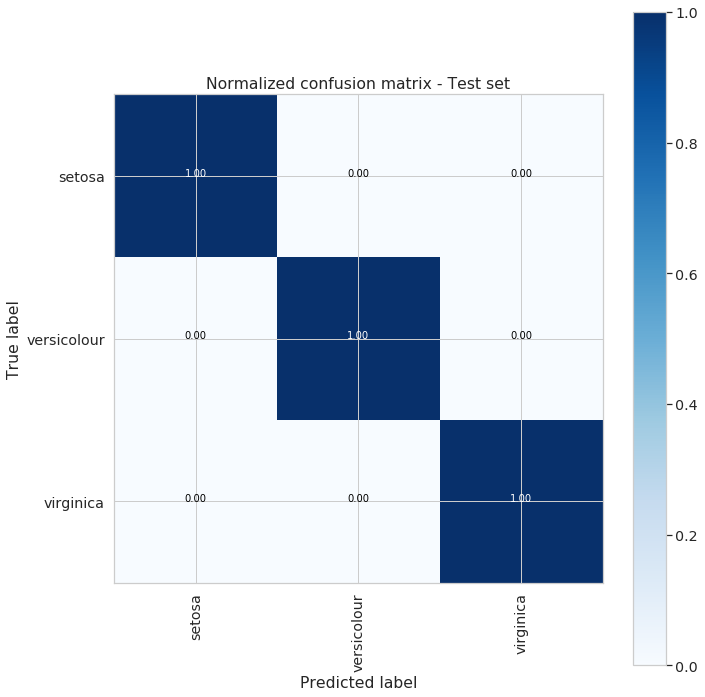

In [21]:
# confusion matrix
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(
    cm=confusion_matrix(y_test, yPredsTest),
    classes=classLabels,
    normalize=True,
    title="Normalized confusion matrix - Test set",
)

plt.show()

> The test class is perfectly classified